![header](../figures/logos_partenaires._cmems_se.jpg)

# Benchmark DUACS sea surface height maps

<div style="text-align: right"><i> 2023-04-27 DUACS_SSH_BENCHMARK_DEMO </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of DUACS sea surface height maps</center></h1>
<h5> The notebook aims to evaluate the sea surface height maps produced by the DUACS system. </h5>
    <h5> These maps are equivalent to the SEALEVEL_GLO_PHY_L4_MY_008_047 product distributed by the Copernicus Marine Service, except that a nadir altimeter (SARAL/Altika, SEALEVEL_GLO_PHY_L3_MY_008_062 product) has been excluded from the mapping. </h5>
        <h5> We provide below a demonstration of the validation of these maps against the independent SSH data from the Saral/AltiKa altimeter distributed by CMEMS </h5>
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can evaluated sea surface height maps with independent alongtrack data: statistical and spectral analysis</li>
</ul>
    
</div>

In [1]:
from glob import glob
import numpy as np
import os

In [2]:
os.chdir('/Odyssey/private/rfablet/Python/2023a_SSH_mapping_OSE/nb_diags_global')

In [3]:
import sys
sys.path.append('../')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [4]:
import sys
sys.path.append('../')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [5]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [6]:
if False :
    path_dir = '/Odyssey/private/rfablet/Python/4dvarnet-global-mapping/inference/output/'

    if True :
        nc_file_1 = path_dir + 'unet+-run2-8th-best-to8th-1.nc'
        nc_file_2 = path_dir + 'unet+-run2-8th-best-to8th-2.nc'
        nc_file_3 = path_dir + 'unet+-run2-8th-best-to8th-3.nc'
        nc_file_4 = path_dir + 'unet+-run2-8th-best-to8th-4.nc'

    if False :
        nc_file_1 = path_dir + 'unet-run2-4th-best-to8th-1.nc'
        nc_file_2 = path_dir + 'unet-run2-4th-best-to8th-2.nc'
        nc_file_3 = path_dir + 'unet-run2-4th-best-to8th-3.nc'
        nc_file_4 = path_dir + 'unet-run2-4th-best-to8th-4.nc'

    if False :
        nc_file_1 = path_dir + 'unet-run2-8th-best-to8th-1.nc'
        nc_file_2 = path_dir + 'unet-run2-8th-best-to8th-2.nc'
        nc_file_3 = path_dir + 'unet-run2-8th-best-to8th-3.nc'
        nc_file_4 = path_dir + 'unet-run2-8th-best-to8th-4.nc'

    if True :
        nc_file_1 = path_dir + 'unet+-run2-8th-best-v1-to8th-1.nc'
        nc_file_2 = path_dir + 'unet+-run2-8th-best-v1-to8th-2.nc'
        nc_file_3 = path_dir + 'unet+-run2-8th-best-v1-to8th-3.nc'
        nc_file_4 = path_dir + 'unet+-run2-8th-best-v1-to8th-4.nc'


    isel1 = dict(time=slice('2019-01-01', '2019-03-15'))
    isel2 = dict(time=slice('2019-03-16', '2019-07-15'))
    isel3 = dict(time=slice('2019-07-16', '2019-10-15'))
    isel4 = dict(time=slice('2019-10-16', '2019-12-31'))

    ds1 = xr.open_dataset(nc_file_1).sel(isel1)
    ds2 = xr.open_dataset(nc_file_2).sel(isel2)
    ds3 = xr.open_dataset(nc_file_3).sel(isel3)
    ds4 = xr.open_dataset(nc_file_4).sel(isel4)


    sla_all = np.concatenate((ds1['sla'].values, ds2['sla'].values, ds3['sla'].values, ds4['sla'].values), axis=0)
    time_all = np.concatenate((ds1['time'].values, ds2['time'].values, ds3['time'].values, ds4['time'].values), axis=0)

    ds_all = ds = xr.Dataset(
        data_vars=dict(
            sla=(["time", "latitude", "longitude"], sla_all),
        ),
        coords=dict(
            time=time_all,
            longitude=ds1['longitude'].values,
            latitude=ds1['latitude'].values,
        ),
    )
    ds_all.latitude.attrs["units"] = "degrees_north"
    ds_all.longitude.attrs["units"] = "degrees_east"

    ds_all.to_netcdf(nc_file_1.replace('-1.nc','.nc') )

    ds = xr.open_dataset(nc_file_1.replace('-1.nc','.nc'))
    ds

In [ ]:
time_min = '2018-12-31'                                        # time min for analysis
time_max = '2020-01-01'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')

ckpt_res = 'unet-4th-glo12-sla.nc'
#ckpt_res = 'unet-noise2-gloss+-4th-glo12-sla-last2.nc'
ckpt_res = 'unet-noise2-4th-glo12-sla-last.nc'
ckpt_res = 'unet-noise2-4th-glo12-sla-best2.nc'
ckpt_res = 'unet-noise2+-4th-glo12-sla-best.nc'
ckpt_res = 'unet-noise2+-4th-glo12-sla-last.nc'
ckpt_res = 'unet-noise2+-4th-glo12-sla-best-to-8th.nc'

ckpt_res = 'unet-noise2-8th-glo12-sla-last-to4th.nc'
ckpt_res = 'unet-noise2-8th-glo12-sla-last-to8th.nc'
ckpt_res = 'unet-noise2-8th-glo12-sla-best-to8th.nc'
ckpt_res = 'unet-wlonlat-noise-8th-glo12-sla-last-to8th.nc'

ckpt_res = 'unet-wlonlat-noise-8th-glo12-sla-last-to8th.nc'

#ckpt_res = 'unet-osse-osse-4th-small-batches-best-to4th.nc'
ckpt_res = 'unet-osse-osse-4th-small-batches-best-to4th.v0.nc' # normalisation mean,std
ckpt_res = 'unet-osse-osse-4th-small-batches-best-to4th.v1.nc' # normalisation [0. 0.1]
#ckpt_res = 'unet-osse-osse-4th-small-batches-2016-2018-best-to4th.v1.nc' # normalisation [0. 0.1]

ckpt_res = 'unet-osse-osse-4th-best-to4th.nc'
ckpt_res = 'unet-osse-osse-4th-best-to4th.v1.nc' # normalisation from training config (0., 0.1)
ckpt_res = 'unet-osse-osse-4th-best-to4th.v2.nc' # normalisation from patch
ckpt_res = 'unet-osse-osse-4th-best-to4th.v3.nc' # normalisation from patch + reprocessing

ckpt_res = 'unet-osse-osse-4th-small-batches-inp-prepro-best-to4th.nc' # inp. preprocessing
ckpt_res = 'unet-run2-4th-best-to4th.nc'
ckpt_res = 'unet-run2-osse-ose-prepro-4th-best-to4th.nc'
ckpt_res = 'unet-run2-osse-only-4th-best-to4th.nc'
ckpt_res = 'unet-run2-osse-osse-4th-best-to4th.nc'

ckpt_res = 'unet-osse-osse-4th-noise2-best-to4th.nc'
#ckpt_res = 'unet-osse-osse-4th-noise2--best-to4th.nc'

#ckpt_res = 'unet-1000epochs-run2-4th-best-to4th.nc'
#ckpt_res = 'unet+-run2-8th-best-v3-mdt8th-to4th.nc'
#ckpt_res = 'unet+-run2-8th-best-v3-nointerp2-to4th.nc'

ckpt_res = 'unet-1000epochs-run2-4th-best-cubic-to4th.nc'

#ckpt_res = 'unet-run2-8th-best-to4th.nc'
#ckpt_res = 'unet-run2-8th-best-to8th.nc'
#ckpt_res = 'unet+-run2-8th-best-to8th.nc'
#ckpt_res = 'unet+-run2-8th-best-v1-to8th.nc'
#ckpt_res = 'unet-interp-silu-4th-best-to4th.nc'
#ckpt_res = 'unet-interp-relu-4th-best-to4th.nc'

#ckpt_res = 'fdv++-4th-best-to4th.nc'
#ckpt_res = 'fdv++-4th-run2-best-to4th.nc'
#ckpt_res = 'fdv++-4th-best-v1-to4th.nc'

#method_name = 'C-unet-noise2-4th-glo12'
method_name = 'C-'+ckpt_res.replace('.nc','')
method_path = (
    '/Odyssey/private/rfablet/Python/4dvarnet-global-mapping/inference/output/'
    + ckpt_res
)
stat_output_filename = f'{output_dir}/stat_sla_{method_name}.nc'  # output statistical analysis filename
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_sla_{method_name}.nc'    # output spectral analysis filename
segment_lenght = 1000.                                         # spectral parameer: along-track segment lenght in kilometer to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## Sea Surface Height from Saral/AltiKa

In [8]:
%%time
# list_of_file = sorted(glob('../data/independent_alongtrack/alg/2019/*.nc'))
# ds_alg = xr.open_mfdataset(list_of_file, combine='nested', concat_dim='time')
# ds_alg = ds_alg.where((ds_alg.time >= np.datetime64(time_min)) & (ds_alg.time <=  np.datetime64(time_max)), drop=True)
# ds_alg = ds_alg.sortby('time')

ds_alg = xr.open_dataset('/Odyssey/private/rfablet/Python/2023a_SSH_mapping_OSE/data/independent_alongtrack/masked-alg.nc')
ds_alg

CPU times: user 774 ms, sys: 146 ms, total: 920 ms
Wall time: 1.03 s


<xarray.Dataset> Size: 1GB
Dimensions:         (time: 14437696)
Coordinates:
  * time            (time) datetime64[ns] 116MB 2019-01-01T00:04:07.003014144...
    longitude       (time) float64 116MB ...
    latitude        (time) float64 116MB ...
Data variables:
    cycle           (time) float32 58MB ...
    track           (time) float32 58MB ...
    sla_unfiltered  (time) float64 116MB ...
    sla_filtered    (time) float64 116MB ...
    dac             (time) float64 116MB ...
    ocean_tide      (time) float64 116MB ...
    internal_tide   (time) float64 116MB ...
    lwe             (time) float64 116MB ...
    mdt             (time) float64 116MB ...
    tpa_correction  (time) float64 116MB ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P24H11M29.716548S
    time_coverage_end:               2019-01-01T23:36:52Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2018-12-31T23:25:22Z
    title:                           DT Altika Drifting Phase Global Ocean Al...
    description:                     Added DUACS, MIOST and NeurOST SSH's mas...

## Sea Level Anomalies maps to evaluate

In [24]:
%%time
# Load and process mapping
ds_maps = xr.open_dataset(method_path).sel(time=slice(time_min, time_max))

interp = False
if interp :
    mdt = xr.open_dataset("/Odyssey/public/duacs/2019/from-datachallenge-global-ose-2023/MDT_DUACS_0.25deg.nc")
    mdt = mdt.sel(latitude=slice(ds_maps.latitude[0],ds_maps.latitude[-1] + 0.26,),
                longitude=slice(ds_maps.longitude[0],ds_maps.longitude[-1] + 0.26,),)


    mask = mdt.where(mdt.isnull(), 0.0)

    ds_maps_interp = ds_maps.interp( coords=dict(latitude=mdt.latitude,
                                        longitude=mdt.longitude,),
                                    method='linear', ) #"linear",) )
    ds_maps_interp.sla.values = ds_maps_interp.sla.values + mask.mdt.values[None,:,:]
    ds_maps = ds_maps_interp.sel(latitude=slice(ds_maps.latitude.min(), ds_maps.latitude.max()))

if False:
    ds_maps = xr.Dataset(
        data_vars=dict(
            sla=(["time", "latitude", "longitude"], ds_maps['sla'].values),
        ),
        coords=dict(
            time=ds_maps['time'].values+np.timedelta64(12, 'h'),
            longitude=ds_maps['longitude'].values,
            latitude=ds_maps['latitude'].values,
        ),
    )
    ds_maps.latitude.attrs["units"] = "degrees_north"
    ds_maps.longitude.attrs["units"] = "degrees_east"
ds_maps

CPU times: user 6.86 ms, sys: 5.86 ms, total: 12.7 ms
Wall time: 172 ms


<xarray.Dataset> Size: 3GB
Dimensions:    (time: 367, latitude: 640, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2018-12-31 2019-01-01 ... 2020-01-01
  * latitude   (latitude) float32 3kB -78.88 -78.62 -78.38 ... 80.38 80.62 80.88
  * longitude  (longitude) float64 12kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    sla        (time, latitude, longitude) float64 3GB ...

In [ ]:
#ds_maps = ds_maps_interp
#ds_maps = xr.open_dataset(method_path).sel(time=slice(time_min, time_max))
#ds_maps

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 367, latitude: 639, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2018-12-31 2019-01-01 ... 2020-01-01
  * latitude   (latitude) float32 3kB -78.88 -78.62 -78.38 ... 80.12 80.38 80.62
  * longitude  (longitude) float64 12kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    sla        (time, latitude, longitude) float64 3GB nan nan ... 0.1045 nan

In [16]:
mdt = xr.open_dataset("/Odyssey/public/duacs/2019/from-datachallenge-global-ose-2023/MDT_DUACS_0.25deg.nc")
mdt

<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 12kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    mdt        (latitude, longitude) float64 8MB ...

In [11]:
pwd

'/Odyssey/private/rfablet/Python/2023a_SSH_mapping_OSE/nb_diags_global'

In [ ]:
merge_with_duacs = False

if True :
 
    if True:
        # Load DUACS data
        # Load DUACS data
        list_of_maps = sorted(glob('/Odyssey/public/duacs/2019/from-datachallenge-global-ose-2023/DUACS_global_allsat-alg/*.nc'))
        ds_duacs_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
        ds_duacs_maps = ds_duacs_maps.sel(time=slice(time_min, time_max))
        ds_duacs_maps = ds_duacs_maps.sel(latitude=slice(np.min(ds_maps['latitude'].values), np.max(ds_maps['latitude'].values)))


        ds_duacs_maps.to_netcdf('/Odyssey/private/rfablet/Python/2023a_SSH_mapping_OSE/duacs_global_allsat-alg_gridfdv_2019.nc' )
    else:
        ds_duacs_maps = xr.open_dataset('./dUacs_global_allsat-alg_gridfdv_2019.nc')

if merge_with_duacs :
    # merge duacs and maps for subdomains
    ds_maps_1 = ds_maps.sel(latitude=slice(-75, 75))
    ds_maps_2 = ds_duacs_maps.sel(latitude=slice(-90, -75))
    ds_maps_3 = ds_maps.sel(latitude=slice(75, 90))

    ds_maps = xr.merge([ds_maps_1, ds_maps_2, ds_maps_3], compat='override')
    
ds_maps

In [54]:
if False:
    plt.imshow(np.flipud(im), vmin=-1., vmax=1., cmap='RdBu_r')
    plt.colorbar(label='Sea Level Anomaly (m)')
    plt.title('Estimated Sea Level Anomaly')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    plt.imshow(np.flipud(im_duacs), vmin=-1., vmax=1., cmap='RdBu_r')
    plt.colorbar(label='Sea Level Anomaly (m)')
    plt.title('DUACS Sea Level Anomaly')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [55]:
if False:      
    # # plot a map
    im = ds_duacs_maps['sla'].values[0,:,:]
    im = ds_duacs_maps_new['sla'].values[0,:,:]
    im = ds_maps['sla'].values[0,:,:]

    #diff = ds_duacs_maps_new['sla'].values[0,:,:] - ds_maps['sla'].values[0,:,:]

    plt.imshow(im, vmin=-1., vmax=1., cmap='RdBu_r')
    plt.colorbar(label='Sea Level Anomaly (m)')
    plt.title('DUACS Sea Level Anomaly')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface height maps onto along-track positions

In [25]:
ds_interp = run_interpolation(ds_maps, ds_alg)
ds_interp = ds_interp.dropna('time')
print(ds_interp.sla_unfiltered.count().item())
ds_interp

2025-08-28 22:46:23 INFO     fetch data from 2018-12-31 00:00:00 to 2019-02-01 00:00:00
2025-08-28 22:46:34 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2025-08-28 22:46:42 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2025-08-28 22:46:50 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2025-08-28 22:46:54 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2025-08-28 22:46:58 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2025-08-28 22:47:02 INFO     fetch data from 2019-06-30 00:00:00 to 2019-08-01 00:00:00
2025-08-28 22:47:06 INFO     fetch data from 2019-07-31 00:00:00 to 2019-09-01 00:00:00
2025-08-28 22:47:10 INFO     fetch data from 2019-08-31 00:00:00 to 2019-10-01 00:00:00
2025-08-28 22:47:13 INFO     fetch data from 2019-09-30 00:00:00 to 2019-11-01 00:00:00
2025-08-28 22:47:17 INFO     fetch data from 2019-10-31 00:00:00 to 2019-12-01 00:00:00
2025-08-28 22:47:21 INFO     fet

13812347


<xarray.Dataset> Size: 1GB
Dimensions:            (time: 13812347)
Coordinates:
  * time               (time) datetime64[ns] 110MB 2019-01-01T00:04:18.619014...
Data variables: (12/13)
    cycle              (time) float32 55MB 126.0 126.0 126.0 ... 136.0 136.0
    track              (time) float32 55MB 9.0 9.0 9.0 9.0 ... 408.0 408.0 408.0
    sla_unfiltered     (time) float64 110MB 0.074 0.071 0.121 ... 0.056 0.01
    sla_filtered       (time) float64 110MB 0.066 0.066 0.073 ... 0.031 0.027
    dac                (time) float64 110MB 0.343 0.344 0.344 ... 0.171 0.172
    ocean_tide         (time) float64 110MB -0.104 -0.104 ... -0.304 -0.314
    ...                 ...
    lwe                (time) float64 110MB -0.017 -0.016 -0.016 ... 0.014 0.016
    mdt                (time) float64 110MB -0.134 -0.136 ... -1.138 -1.154
    tpa_correction     (time) float64 110MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude          (time) float64 110MB 63.49 63.4 63.31 ... 246.6 246.3
    latitude           (time) float64 110MB 70.51 70.57 70.62 ... -69.32 -69.55
    msla_interpolated  (time) float64 110MB 0.1277 0.1212 ... 0.01384 0.02476

In [26]:
# 14021469 / 13812347

print('.. number of sla points ', np.sum( np.isnan( ds_interp['msla_interpolated'].values ) == False ))
print('.. fractions of nan ', np.sum( np.isnan( ds_interp['msla_interpolated'].values ) == True ) / ds_interp['msla_interpolated'].values.shape[0] )

.. number of sla points  13812347
.. fractions of nan  0.0


In [17]:
ds_interp

<xarray.Dataset> Size: 1GB
Dimensions:            (time: 13812347)
Coordinates:
  * time               (time) datetime64[ns] 110MB 2019-01-01T00:04:18.619014...
Data variables: (12/13)
    cycle              (time) float32 55MB 126.0 126.0 126.0 ... 136.0 136.0
    track              (time) float32 55MB 9.0 9.0 9.0 9.0 ... 408.0 408.0 408.0
    sla_unfiltered     (time) float64 110MB 0.074 0.071 0.121 ... 0.056 0.01
    sla_filtered       (time) float64 110MB 0.066 0.066 0.073 ... 0.031 0.027
    dac                (time) float64 110MB 0.343 0.344 0.344 ... 0.171 0.172
    ocean_tide         (time) float64 110MB -0.104 -0.104 ... -0.304 -0.314
    ...                 ...
    lwe                (time) float64 110MB -0.017 -0.016 -0.016 ... 0.014 0.016
    mdt                (time) float64 110MB -0.134 -0.136 ... -1.138 -1.154
    tpa_correction     (time) float64 110MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude          (time) float64 110MB 63.49 63.4 63.31 ... 246.6 246.3
    latitude           (time) float64 110MB 70.51 70.57 70.62 ... -69.32 -69.55
    msla_interpolated  (time) float64 110MB 0.1299 0.1251 ... 0.01451 0.0217

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

Once the maps have been interpolated to the position of the along-track, it is possible to calculate different statistics on the time series SLA_alongtrack and SLA_maps. 

We propose below the following statistics: error variance maps (static by 1°x1° box), explained variance maps, temporal evolution of global error variance and explained variance. 

These statistics are also applied to the filtered signals focusing on the 65-500km scale range. A bandpass filter is applied before calculating the scores.  

In [27]:
#compute_stat_scores(ds_interp, lambda_min, lambda_max, stat_output_filename,method_name)

ds_interp['mapping_err'] = ds_interp['msla_interpolated'] - (ds_interp['sla_unfiltered'] - ds_interp['lwe'])
    
print('Total RMSE=',np.sqrt(np.mean(ds_interp['mapping_err'].values**2)),'m') 
print('Total RMSE score=',1-np.sqrt(np.mean(ds_interp['mapping_err'].values**2))/np.sqrt(np.mean((ds_interp['sla_unfiltered'] - ds_interp['lwe']).values**2)),'m')   

Total RMSE= 0.037699036900317 m
Total RMSE score= 0.7094046383568275 m


```
Total RMSE= 0.039786029332299196 m
Total RMSE score= 0.6929505087058931 m
```

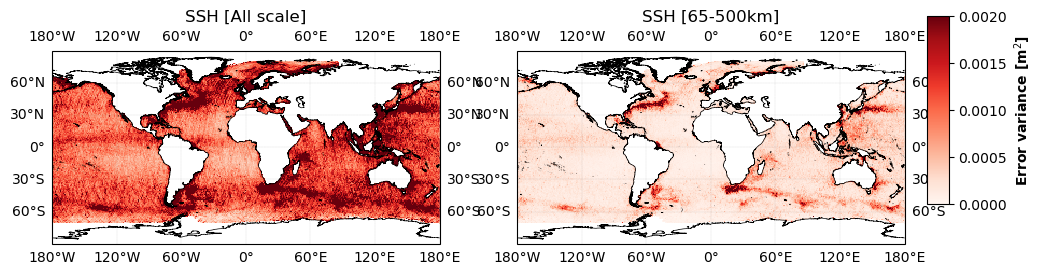

Error in callback <function flush_figures at 0x7db7ec046b00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [126]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map(stat_output_filename)
# Matplotlib
plot_stat_score_map_png(stat_output_filename)

In [ ]:
plot_stat_score_timeseries(stat_output_filename)

:Layout
   .Overlay.I  :Overlay
      .Curve.All_scale :Curve   [time]   (timeserie_variance_mapping_err)
      .Curve.Filtered  :Curve   [time]   (timeserie_variance_mapping_err)
   .Overlay.II :Overlay
      .Curve.All_scale :Curve   [time]   (explained_variance_score)
      .Curve.Filtered  :Curve   [time]   (explained_variance_score)

In [ ]:
plot_stat_by_regimes(stat_output_filename)

,mapping_err_var [m²],sla_unfiltered_var [m²],mapping_err_filtered_var [m²],sla_filtered_var [m²],var_score_allscale,var_score_filtered
coastal,0.002074,0.007916,0.000477,0.001784,0.738039,0.732511
offshore_highvar,0.002874,0.053268,0.000980,0.021747,0.946048,0.954950
offshore_lowvar,0.001197,0.006298,0.000244,0.001785,0.809914,0.863251
equatorial_band,0.001346,0.005907,0.000323,0.000518,0.772046,0.375803
arctic,0.001622,0.003858,0.000301,0.000608,0.579467,0.505238
antarctic,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
plot_stat_by_regimes(stat_output_filename)[['var_score_allscale', 'var_score_filtered']]

,var_score_allscale,var_score_filtered
coastal,0.738039,0.732511
offshore_highvar,0.946048,0.954950
offshore_lowvar,0.809914,0.863251
equatorial_band,0.772046,0.375803
arctic,0.579467,0.505238
antarctic,NaN,NaN


## 2.3 Compute Spectral scores

In [59]:
compute_psd_scores_v2(ds_interp, psd_output_filename, lenght_scale=segment_lenght,method_name=method_name)

2025-08-28 12:38:47 INFO     Segment computation...
2025-08-28 12:39:08 INFO     Spectral analysis...


KeyboardInterrupt: 

Averaged effective resolution: 221.25193391448943 km


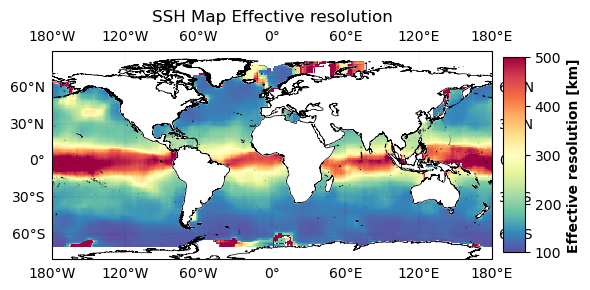

In [ ]:
# Plot effective resolution
# Hvplot
# plot_effective_resolution(psd_output_filename)
# Matplotlib
plot_effective_resolution_png(psd_output_filename)

In [ ]:
plot_psd_scores(psd_output_filename)

BokehModel(combine_events=True, render_bundle={'docs_json': {'5865260b-0a9c-46b1-900b-293e55921624': {'version…

The interactive plot above allows you to explore the spectral metrics by latitude / longitude box